### 引入套件和iris資料庫

In [1]:
import pandas as pd

In [2]:
# 必要ライブラリの宣言
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 学習用データ準備
from sklearn.datasets import load_iris
iris = load_iris()
x_org, y_org, feature, target_feture = iris.data, iris.target, iris.feature_names, iris.target_names

# 取出所有花朵特徵
x_select = x_org
print('陣列形狀', x_select.shape, y_org.shape)

陣列形狀 (150, 4) (150,)


In [4]:
# ダミー変数を追加
x_all = np.insert(x_select, 0, 1.0, axis=1)

### onehotvector化併分割訓練組與測試組

In [5]:
# yをOne-hot-Vectorに
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False,categories='auto')#將資料分類為0、1、2(三類)
y_work = np.c_[y_org]#轉為二維型態才能進行encoding
y_all_one = ohe.fit_transform(y_work)#encoding
print('y的原陣列形狀', y_org.shape)
print('二維化後', y_work.shape)
print('One Hot Vector化後', y_all_one.shape)

y的原陣列形狀 (150,)
二維化後 (150, 1)
One Hot Vector化後 (150, 3)


d:\ProgramData\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [6]:
# 学習データ、検証データに分割
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, y_train_one, y_test_one = train_test_split(
    x_all, y_org, y_all_one, train_size=75, test_size=75, random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape, 
    y_train_one.shape, y_test_one.shape)

(75, 5) (75, 5) (75,) (75,) (75, 3) (75, 3)


### 學習用變數設定

In [7]:
# 学習対象の選択
x, yt  = x_train, y_train_one

### 預測函數

In [8]:
# softmax関数 (9.7.3)
def softmax(x):
    x = x.T
    x_max = x.max(axis=0)
    x = x - x_max
    w = np.exp(x)
    return (w / w.sum(axis=0)).T

In [9]:
# 予測値の計算 (9.7.1, 9.7.2)
def pred(x, W):
    return softmax(x @ W)

### 評價函數

In [10]:
# 交差エントロピー関数)(9.5.1)
def cross_entropy(yt, yp):
    return -np.mean(np.sum(yt * np.log(yp), axis=1))

In [11]:
# モデルの評価を行う関数
from sklearn.metrics import accuracy_score

def evaluate(x_test, y_test, y_test_one, W):

    # 予測値の計算(確率値)
    yp_test_one = pred(x_test, W)

    # 確率値から予測クラス(0, 1, 2)を導出
    yp_test = np.argmax(yp_test_one, axis=1)

    # 損失関数値の計算
    loss = cross_entropy(y_test_one, yp_test_one)

    # 精度の算出
    score = accuracy_score(y_test, yp_test)
    return score, loss

### 建構學習模型

In [12]:
def training(nb_epochs,batch_size,alpha,W):
    # M: 訓練用系列データ総数
    M  = x_train.shape[0]
    
    B = batch_size
    
    # 評価結果記録用 (損失関数値と精度)
    history1 = np.zeros((0, 3))


    # 繰り返し回数カウンタ初期化
    epoch = 0
    T = M // B
    t = M % B
    # M可以被batch_size整除
    if t == 0 :
        for epoch in range(nb_epochs):
            
            index = np.random.choice(M,M,replace=False)
            x, yt = x_train[index], y_train_one[index]

            for j in range(0,T):
                
                x_batch, y_batch = x[j*batch_size:(j+1)*batch_size], yt[j*batch_size:(j+1)*batch_size]
              
                # 予測値計算 (順伝播)
                yp = pred(x_batch, W)

                # 誤差の計算 (9.7.4)
                yd = yp - y_batch

                # 重みの更新 (9.7.5)
                W = W - alpha * (x_batch.T @ yd) / B

            next_flag = True
            
            # ログ記録用
            if next_flag: # 1 epoch 終了後の処理
                score, loss = evaluate(
                    x_test, y_test, y_test_one, W)
                history1 = np.vstack((history1,
                    np.array([epoch, loss, score])))
        
            if (epoch % 100 == 0):    
                print("epoch = %d loss = %.10f score = %.4f "
                    % (epoch, loss, score))
        history1
     # M無法被batch_size整除    
    else : 
        for epoch in range(nb_epochs):
            
            index = np.random.choice(M,M,replace=False)
            x, yt = x_train[index], y_train_one[index]
            
            for j in range(0,T):
                
                x_batch, y_batch = x[j*batch_size:(j+1)*batch_size], yt[j*batch_size:(j+1)*batch_size]
                # 予測値計算 (順伝播)
               
                yp = pred(x_batch, W)

                # 誤差の計算 (9.7.4)
                yd = yp - y_batch

                # 重みの更新 (9.7.5)
                W = W - alpha * (x_batch.T @ yd) / B
            
            #將剩下的樣本視為一個batch訓練
            x_batch, y_batch = x[T-t:], yt[T-t:]
            # 予測値計算 (順伝播)
            
            yp = pred(x_batch, W)

            # 誤差の計算 (9.7.4)
            yd = yp - y_batch

            # 重みの更新 (9.7.5)
            W = W - alpha * (x_batch.T @ yd) / t
            
            next_flag = True
            
            # ログ記録用
            if next_flag: # 1 epoch 終了後の処理
                score, loss = evaluate(
                    x_test, y_test, y_test_one, W)
                history1 = np.vstack((history1,
                    np.array([epoch, loss, score])))
            if (epoch % 100 == 0):    
                print("epoch = %d loss = %.10f score = %.4f"
                    % (epoch, loss, score))
        history1
    return pd.DataFrame(W), pd.DataFrame(history1,columns=['epoch', 'loss', 'score'])   

### 初始化變數

In [13]:
# M: 訓練用系列データ総数
M  = x_train.shape[0]
# D: 入力データ次元数
D = x_train.shape[1]
# N: 分類クラス数
N = y_train_one.shape[1]
#初始權重W
array = np.linspace(0.5,1.5,D*N)
W = array.reshape(D,N)
W

array([[0.5       , 0.57142857, 0.64285714],
       [0.71428571, 0.78571429, 0.85714286],
       [0.92857143, 1.        , 1.07142857],
       [1.14285714, 1.21428571, 1.28571429],
       [1.35714286, 1.42857143, 1.5       ]])

### W1, history1 = training(1000, 75, 0.01, ...)

In [14]:
W1, history1 = training(nb_epochs= 1000,batch_size= 75,alpha= 0.01,W = W)
print('\t')
print('權重向量（W）')
print(W1)
print('\t')
print('紀錄表')
print(history1)

epoch = 0 loss = 1.1827352189 score = 0.3733 
epoch = 100 loss = 0.7195701485 score = 0.7467 
epoch = 200 loss = 0.5896510512 score = 0.8533 
epoch = 300 loss = 0.5237934657 score = 0.9067 
epoch = 400 loss = 0.4815674300 score = 0.9067 
epoch = 500 loss = 0.4506572420 score = 0.9067 
epoch = 600 loss = 0.4261810990 score = 0.9200 
epoch = 700 loss = 0.4058254711 score = 0.9333 
epoch = 800 loss = 0.3883460118 score = 0.9600 
epoch = 900 loss = 0.3730065229 score = 0.9600 
	
權重向量（W）
          0         1         2
0  0.676770  0.642709  0.394807
1  1.132335  0.946201  0.278607
2  1.806066  0.796483  0.397451
3  0.013207  1.415485  2.214165
4  0.834170  1.272398  2.179147
	
紀錄表
     epoch      loss     score
0      0.0  1.182735  0.373333
1      1.0  1.142748  0.373333
2      2.0  1.118178  0.373333
3      3.0  1.101556  0.373333
4      4.0  1.088911  0.373333
..     ...       ...       ...
995  995.0  0.359986  0.960000
996  996.0  0.359856  0.960000
997  997.0  0.359726  0.960000
998 

### W2, history2 = training(1000, 35, 0.01, ...)

In [15]:
W2, history2 = training(nb_epochs= 1000,batch_size= 35,alpha= 0.01,W = W)
print('\t')
print('權重向量（W）')
print(W2)
print('\t')
print('紀錄表')
print(history2)

epoch = 0 loss = 1.1230344456 score = 0.3733
epoch = 100 loss = 0.5637110860 score = 0.7067
epoch = 200 loss = 0.4335948099 score = 0.9867
epoch = 300 loss = 0.4233537051 score = 0.8133
epoch = 400 loss = 0.3566315395 score = 0.9333
epoch = 500 loss = 0.3475684024 score = 0.9067
epoch = 600 loss = 0.2868154183 score = 0.9867
epoch = 700 loss = 0.2796311788 score = 0.9600
epoch = 800 loss = 0.2892403651 score = 0.9067
epoch = 900 loss = 0.2606680819 score = 0.9333
	
權重向量（W）
          0         1         2
0  0.761186  0.768637  0.184463
1  1.324802  1.117605 -0.085265
2  2.235604  0.861160 -0.096764
3 -0.550404  1.293095  2.900167
4  0.571802  0.967712  2.746200
	
紀錄表
     epoch      loss     score
0      0.0  1.123034  0.373333
1      1.0  1.133931  0.266667
2      2.0  1.086555  0.320000
3      3.0  1.032925  0.373333
4      4.0  1.067051  0.266667
..     ...       ...       ...
995  995.0  0.242244  0.960000
996  996.0  0.256646  0.920000
997  997.0  0.236838  0.960000
998  998.0  0.

### W3, history3 = training(1000, 1, 0.01, ...)

In [16]:
W3, history3 = training(nb_epochs= 1000,batch_size= 1,alpha= 0.01,W = W)
print('\t')
print('權重向量（W）')
print(W3)
print('\t')
print('紀錄表')
print(history3)

epoch = 0 loss = 0.7631290210 score = 0.7333 
epoch = 100 loss = 0.1734213404 score = 0.9200 
epoch = 200 loss = 0.0950979031 score = 0.9867 
epoch = 300 loss = 0.1055888877 score = 0.9467 
epoch = 400 loss = 0.0738807319 score = 0.9867 
epoch = 500 loss = 0.1059843241 score = 0.9333 
epoch = 600 loss = 0.1103407315 score = 0.9333 
epoch = 700 loss = 0.1777935956 score = 0.9200 
epoch = 800 loss = 0.0668001753 score = 0.9733 
epoch = 900 loss = 0.1070723051 score = 0.9333 
	
權重向量（W）
          0         1         2
0  1.205954  2.610215 -2.101883
1  2.456863  1.499836 -1.599556
2  4.672005  1.791192 -3.463197
3 -3.656618  1.123650  6.175825
4 -1.051742 -1.582370  6.919826
	
紀錄表
     epoch      loss     score
0      0.0  0.763129  0.733333
1      1.0  0.758017  0.626667
2      2.0  0.953641  0.480000
3      3.0  0.496898  0.733333
4      4.0  0.477604  0.733333
..     ...       ...       ...
995  995.0  0.106730  0.933333
996  996.0  0.094588  0.946667
997  997.0  0.100842  0.933333
998 

### 三種方式下 loss function的遞減情形

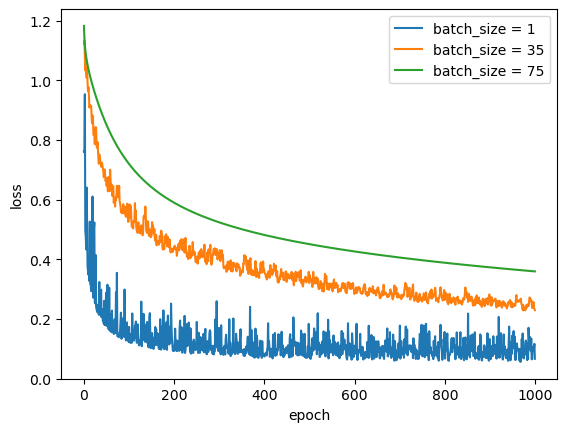

In [17]:
plt.plot(history3['loss'])
plt.plot(history2['loss'])
plt.plot(history1['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['batch_size = 1','batch_size = 35','batch_size = 75'])

### 三種方式下 精確度的提升

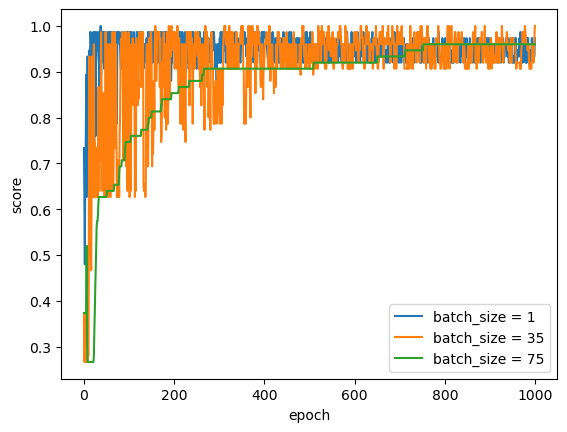

In [18]:
plt.plot(history3['score'])
plt.plot(history2['score'])
plt.plot(history1['score'])
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['batch_size = 1','batch_size = 35','batch_size = 75'])